In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
from scipy.signal import convolve2d
import numba as nb
from IPython.display import Markdown, display,HTML,Image
from z3 import *

### Puzzle as published 
https://www.janestreet.com/puzzles/hooks-8-index/

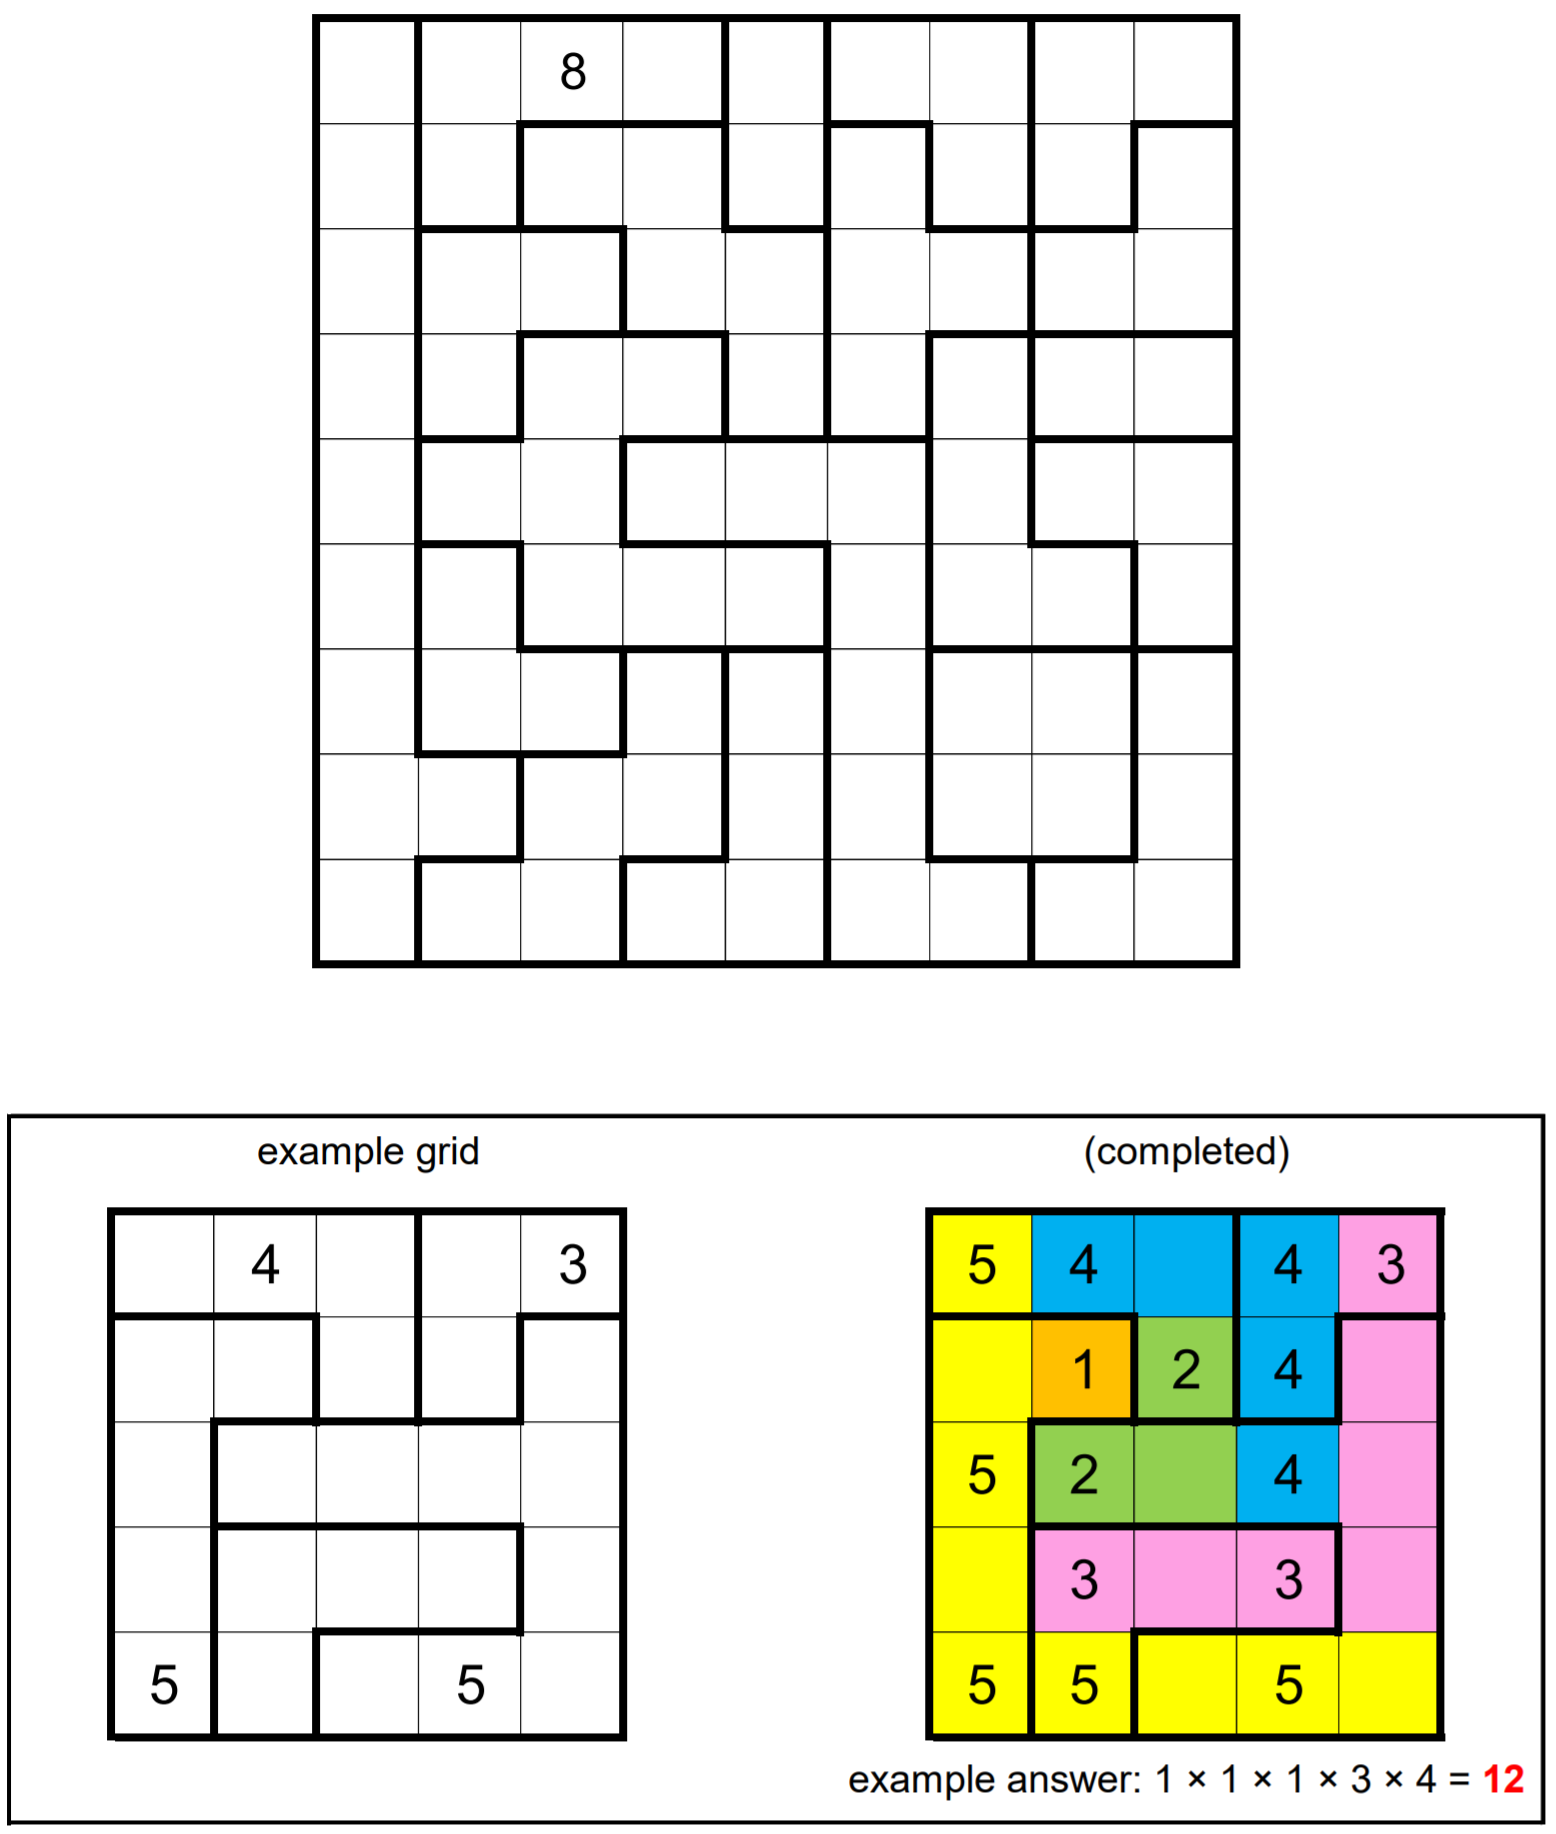

### Hooks 8

The grid above can be partitioned into 9 L-shaped “hooks”. The largest
is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains
15 squares), and so on. The smallest hook is just a single
square. Find where the hooks are located, and place nine 9’s in one of
the hooks, eight 8’s in another, seven 7’s in another, and so on.
The filled squares must form a connected region. (Squares are
“connected” if they are orthogonally adjacent.) Furthermore, every
2-by-2 region must contain at least one unfilled square.
The sum of the values in each of the connected regions must be
the same.
The answer to this puzzle is the product of the areas of the connected
groups of empty squares in the completed grid.

In [7]:
# Hooks again but the change is the nxn hook does not have to contain n's.
# Also shows up a issue in my connectivitity calcs when looking for valid grids,which excluded the right answer. Now 
# it's only checked at the end but makes it a lot slower. Used z3 to speed up the final placements (~20 times faster than
# numba enhanced backtracking !!) so got the speed down.  

url='https://www.janestreet.com/puzzles/hooks-8-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/2022-01-01-hooks-8.png',width=400))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[11:15]))))


In [18]:
# Setup the constraints
# use 20 for the filled cells and treat as smaller 
# group with a different total


groups = np.array([[ 1, 0, 0, 0, 2, 3, 3, 4, 4],
                   [ 1, 0, 5, 5, 2,14, 3, 4, 7],
                   [ 1, 8, 8, 5, 5,14,14, 7, 7],
                   [ 1, 8, 9, 9, 5,14,10,11,11],
                   [ 1, 9, 9,12,12,12,10,13,13],
                   [ 1, 6, 9, 9, 9,12,10,10,13],
                   [ 1, 6, 6,15,16,12,17,17,18],
                   [ 1, 1,15,15,16,12,17,17,18],
                   [ 1,15,15,16,16,12,12,18,18]])

In [21]:
def sol_print(solved,matrix,groups):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] =""
    groups_fixed = dcopy(groups)
    groups_fixed[0,2] = 0
    ax1 =sns.heatmap(solved,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=2,ax=ax[0],linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax2 =sns.heatmap(groups_fixed,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=2,ax=ax[1],linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()
    
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def areas(grid):
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))
    print(areas)
    return np.prod(areas)

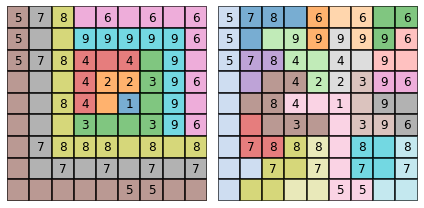

Took 9.7110 seconds
[ 1.  1.  1.  2.  1.  1.  1. 17.  5.  1.  1.  4.]
solution is 680


In [29]:
start = time.time()
N =9
#set up the solver and variables.
s = Tactic("qffd").solver()

# H== hooks
H = np.array(IntVector("h",N**2),dtype=object).reshape((N,N))

row_fix =IntVector("r",N)
col_fix =IntVector("c",N)

s += [And(e>0,e<=N) for (i,j),e in np.ndenumerate(H)]
s += [And(e>=0,e<N) for e in row_fix+col_fix]

s += Distinct(row_fix)
s += Distinct(col_fix)

for n in range(1,N+1):
    s+=PbEq([(e==n,1) for _,e in np.ndenumerate(H)],2*n-1)
    if n!=1:
        s+=PbEq([(If(e==int(n),Sum([H[k,l] ==int(n) for k,l in neigh(i,j,N)]),0)==1,1)                 
                        for (i,j),e in np.ndenumerate(H)],2)
        
for n in range(N):
    s += [Implies(e == int(n+1),Or(i == row_fix[n],j == col_fix[n])) for (i,j),e in np.ndenumerate(H)]
    
# X== nums  
X = np.array(IntVector("x",N**2),dtype=object).reshape((N,N))    
hook_num = IntVector("n",N)

s += [And(e>0,e<N+1) for e in hook_num]
s += [And(e>0,e<N+1) for (i,j),e in np.ndenumerate(X)]
s += Distinct(hook_num)

for n in range(N):
    s += [Implies(e==n+1,X[i,j]==hook_num[n]) for (i,j),e in np.ndenumerate(H)]

# Y = filled    
Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))
s += [Or(e==0,e==1) for (i,j),e in np.ndenumerate(Y)]

for n in range(1,N+1):
    s+=PbEq([(And(e==n,Y[i,j]==1),1) for (i,j),e in np.ndenumerate(X)],n)

# no 2x2
s += [Or(Y[i,j] ==0,Y[i+1,j] ==0,Y[i,j+1] ==0,Y[i+1,j+1] ==0) for j in range(N-1) for i in range(N-1)]
    
edge ={}
Z = np.array(IntVector('z', N*N),dtype=object).reshape(N,N)

# create edges and variable to define order in connectivity tree
for i in range(N):
    for j in range(N):  
        for (k,l) in neigh(i,j,N):
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
            s+=Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)] ==1)

# no edges into or out of unfilled cells. Only one edge per cell     
for i in range(N):
    for j in range(N):       
        s += Implies(Y[i,j] ==0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] ==0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] > 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) <= 1)

        for (k,l) in neigh(i,j,N):
            # Make edges one way to form a tree
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1

    # limit the order values
    s += [And(e>= 0 ,e <=int(N*N)) for (i,j),e in np.ndenumerate(Z)]

    # order is ascending along edges
    for i in range(N):
        for j in range(N):            
            s += [Implies(And(Y[i,j]!=0,edge[(k,l,i,j)]==1),Z[i,j] > Z[k,l]) for (k,l) in neigh(i,j,N)]

    # only one cell with no feed in => root
    s += PbEq([(And(Y[i,j] != 0,Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N) ]) == 0),1) for i in range(N) for j in range(N)],1)

#fixed an       
s += X[0,2]==8 
s += And([sum([Y[i,j]*e for (i,j),e in np.ndenumerate(X) if groups[i,j] == g]) == 15 for g in range(19)])
           
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    result_x =  evalu(X)
    result_y =  evalu(Y)
    sol_print(result_x,result_y,groups)
    print("Took {:.4f} seconds".format(time.time()- start))
    soln = result_x*result_y
    print("solution is {:,.0f}".format(areas(soln)))
else:
    print("Fail")

### Solution as published 
https://www.janestreet.com/puzzles/hooks-8-solution/

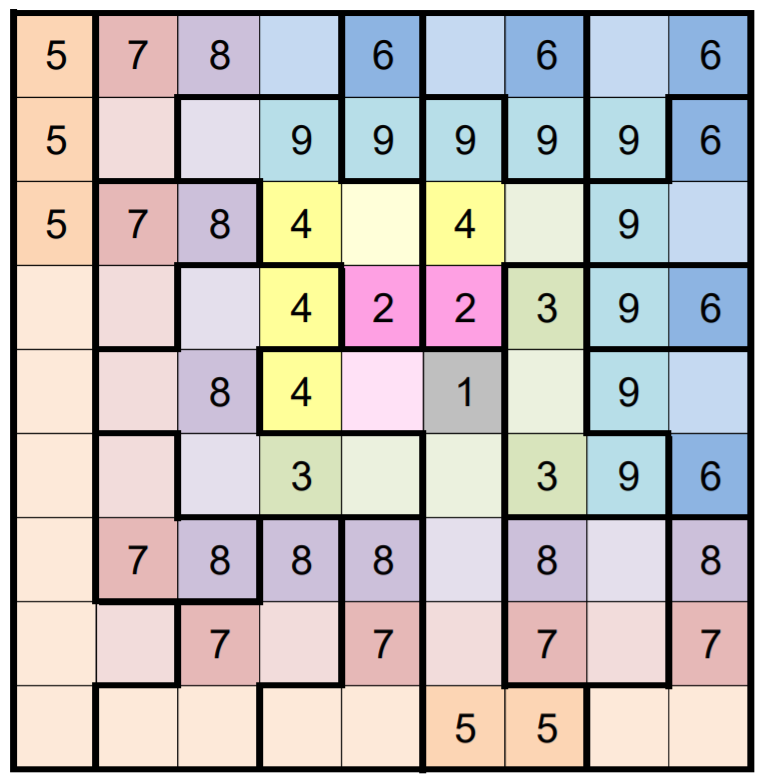

### Hooks 8

The above image shows the shaded L shapes with the assigned numbers that
satisfies the requirements. The empty regions have areas 1, 1, 1, 2,
1, 1, 1, 17, 5, 1, 1, and 4, which multiply to
680
.

In [26]:
url='https://www.janestreet.com/puzzles/hooks-8-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/2022-01-01-hooks-8-solution.png',width=200))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[11:14]))))